<a href="https://colab.research.google.com/github/team-sesac/transformer-for-finance/blob/main/src/ch6_RNN_LSTM/RNN_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q finance-datareader
import FinanceDataReader as fdr
import pandas as pd


In [3]:
df = fdr.DataReader('005930', '2010')
df.shape

(3442, 6)

In [4]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114
2010-01-07,16820,16820,16260,16260,443237,-0.033294
2010-01-08,16400,16420,16120,16420,295798,0.009840


In [5]:
df_ohlcv = df.iloc[:,:-1]
dfx = df_ohlcv.drop(columns='Close')
dfy = df_ohlcv['Close']
dfx.shape, dfy.shape

((3442, 4), (3442,))

In [6]:
from sklearn.preprocessing import MinMaxScaler

mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
x_mms = mmsx.fit_transform(dfx)
y_mms = mmsy.fit_transform(dfy.to_frame())

pd.DataFrame(x_mms).describe()

,0,1,2,3
count,3442.000000,3442.000000,3442.000000,3442.000000
mean,0.453475,0.426929,0.453102,0.070747
std,0.218363,0.205270,0.218479,0.099236
min,0.000000,0.000000,0.000000,0.000000
25%,0.281063,0.264463,0.281117,0.002600
50%,0.385493,0.366322,0.388156,0.004316
75%,0.620155,0.584711,0.619832,0.134469
max,1.000000,1.000000,1.000000,1.000000


In [7]:
x_mms[0:10], y_mms[10]

(array([[0.17785161, 0.16714876, 0.17877095, 0.00264955],
        [0.18294574, 0.17128099, 0.18212291, 0.00619248],
        [0.18361019, 0.17376033, 0.18458101, 0.00509107],
        [0.186268  , 0.17376033, 0.18167598, 0.00490816],
        [0.18161683, 0.1696281 , 0.18011173, 0.0032755 ],
        [0.18183832, 0.17004132, 0.17810056, 0.00441721],
        [0.1765227 , 0.16714876, 0.17765363, 0.00425729],
        [0.17829457, 0.1665186 , 0.17810056, 0.00296346],
        [0.17851606, 0.17169421, 0.17877095, 0.00589888],
        [0.18427464, 0.17417355, 0.1852514 , 0.00441167]]),
 array([0.04211886]))

In [8]:
window_size = 10
x_data = []
y_data = []
for start in range(len(y_mms)-window_size):
  stop = start + window_size
  x_data.append(x_mms[start:stop])
  y_data.append(y_mms[stop])

In [9]:
print(len(y_mms))
print(len(y_data))

3442
3432


In [10]:
import numpy as np
split_size = int(len(x_data)*0.8)
X_train = np.array(x_data[:split_size])
X_test = np.array(x_data[split_size:])
y_train = np.array(y_data[:split_size])
y_test = np.array(y_data[split_size:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2745, 10, 4), (687, 10, 4), (2745, 1), (687, 1))

In [21]:
import torch
import torch.nn as nn

class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_rate=0.5):
        super(BidirectionalLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size1, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size2 * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Assuming X_train[0].shape is (sequence_length, input_features)
input_size = X_train[0].shape[1]
hidden_size1 = 64
hidden_size2 = 32

model = BidirectionalLSTMModel(input_size, hidden_size1, hidden_size2)
print(model)


BidirectionalLSTMModel(
  (lstm1): LSTM(4, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


<Axes: >

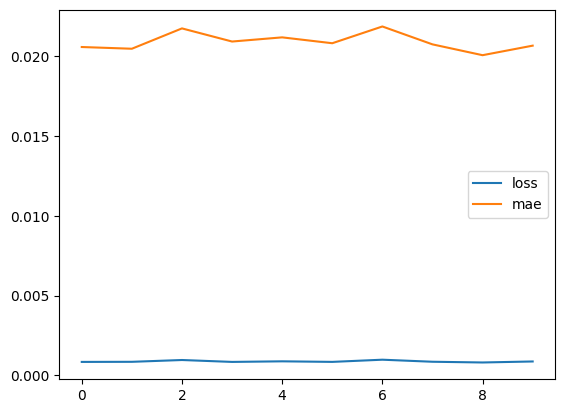

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

# Assuming X_train and y_train are NumPy arrays or PyTorch tensors

# Convert NumPy arrays to PyTorch tensors if needed
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Assuming model is an instance of BidirectionalLSTMModel

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Move the model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Training loop
epochs = 10
batch_size = 32

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

history = {'loss': [], 'mae': []}

for epoch in range(epochs):
    total_loss = 0.0
    total_mae = 0.0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        mae = torch.mean(torch.abs(outputs - targets))

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_mae += mae.item() * len(inputs)

    average_loss = total_loss / len(X_train)
    average_mae = total_mae / len(X_train)

    history['loss'].append(average_loss)
    history['mae'].append(average_mae)

# Convert history to a DataFrame and plot
df_history = pd.DataFrame(history)
df_history[['loss', 'mae']].plot()


In [24]:
# Assuming X_test is a NumPy array or PyTorch tensor

# Convert NumPy array to PyTorch tensor if needed
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Move the model and data to GPU if available
X_test_tensor = X_test_tensor.to(device)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions back to CPU if needed
y_pred = y_pred_tensor.cpu().numpy()

# Convert predictions and ground truth to a DataFrame
df_test = pd.DataFrame(y_test, columns=['test'])
df_test['predict'] = y_pred

# Assuming df has 687 rows and you want to use the last 162 rows for y_test_date
y_test_date = df.iloc[-687:].index

# Convert predictions and ground truth to a DataFrame
df_test = pd.DataFrame(y_test, columns=['test'])
df_test['predict'] = y_pred

# Set the index
df_test.index = y_test_date

In [18]:
df_test

,test,predict
Date,,
2021-03-05,0.885013,0.897450
2021-03-08,0.883721,0.884479
2021-03-09,0.875969,0.891824
2021-03-10,0.869509,0.881003
2021-03-11,0.883721,0.885159
...,...,...
2023-12-06,0.750646,0.755793
2023-12-07,0.748062,0.753613
2023-12-08,0.762274,0.750281


In [25]:
y_predict_inverse = mmsy.inverse_transform(y_pred)
y_test_origin = df.iloc[-len(y_pred):, [-3]]
df_test['test_origin'] = y_test_origin
df_test['predict_origin'] = y_predict_inverse
df_test

,test,predict,test_origin,predict_origin
Date,,,,
2021-03-05,0.885013,0.847551,82100,79200.406250
2021-03-08,0.883721,0.836084,82000,78312.906250
2021-03-09,0.875969,0.835748,81400,78286.890625
2021-03-10,0.869509,0.831405,80900,77950.718750
2021-03-11,0.883721,0.830886,82000,77910.562500
...,...,...,...,...
2023-12-06,0.750646,0.718809,71700,69235.789062
2023-12-07,0.748062,0.715189,71500,68955.632812
2023-12-08,0.762274,0.712398,72600,68739.617188


<Axes: xlabel='Date'>

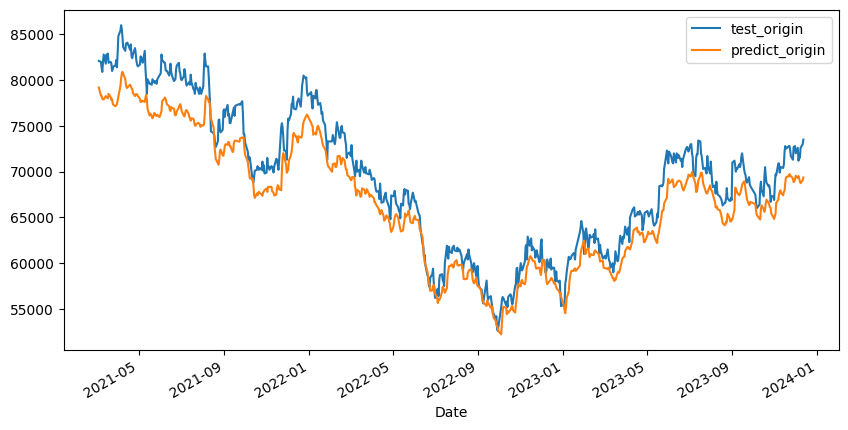

In [26]:
df_test[['test_origin', 'predict_origin']].plot(figsize=(10, 5))